In [1]:
import os
import zipfile
from fairgraph import KGClient
import fairgraph.openminds.core as omcore
import fairgraph.openminds.controlledterms as terms
import fairgraph.openminds.ephys as ephys
import fairgraph.openminds.stimulation as stim
from fairgraph.openminds.core import DatasetVersion
import json
from glob import glob
import numpy as np
from neo import get_io
from neo import io
from neo.io import AxonIO
import pandas as pd
from neo.io import AsciiSignalIO
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [ ]:
client = KGClient(host="core.kg.ebrains.eu", token=clb_oauth.get_token())

#Choose the Dataset with his version
dataset_title = "Excitability of mouse hippocampal CA1 pyramidal neurons during sustained (500 ms) strong depolarization."
dataset_version = "v1"

# Use the follow_links parameter from the by_name method to avoid having to resolve every element of the "has_parts" property later
follow_links = {"versions": {"has_parts":{}}}

# Retrieve correct dataset and select his version
dataset = omcore.Dataset.by_name(dataset_title, client, follow_links= follow_links, scope="any")
datasetVersion = dataset.versions if isinstance(dataset.versions, omcore.DatasetVersion) else [dsv for dsv in dataset.versions if dsv.version_identifier == dataset_version][0]
if not os.path.exists("downloads"):
    dataset_path = dataset_version.download("downloads", client, accept_terms_of_use=True)
with zipfile.ZipFile("downloads/d-cc88a377-b456-4673-a449-07b0e7960ffd.zip", "r") as z:
    z.extractall("downloads")

In [ ]:
# Select all StimulationActivivities from the DatasetVersion's "has_parts" property, no need to resolve
stimAct =[i for i in datasetVersion.has_parts if isinstance(i,stim.StimulationActivity)]

# Get a list of every EphysStimulus associated to each StimulationActivity in stimAct
ephysStim = []
for act in stimAct:
    if isinstance(act.stimuli, list):
        ephysStim.append([i.resolve(client, scope="any") for i in act.stimuli])
    else:
        ephysStim.append([act.stimuli.resolve(client, scope="any")])
# Note: ephysStim is a list of lists
speEphys= ephysStim[0][0].specifications.resolve(client, scope="any")
Metadata = speEphys.configuration

#Retrieve the metadata of the stimulation in configuration 
current_pulse_amplitudes = json.loads(Metadata)["amplitudes"]
onset = json.loads(Metadata)["onset"]
duration = json.loads(Metadata)["duration"]
interval = json.loads(Metadata)["interval"]

#convert value in ms to s
onset = onset/1000
duration = duration/1000
interval = interval/1000

In [2]:
for file_path in glob("downloads/*.ABF")[:3]:
    io = get_io(file_path)
    print(io)

ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable


AxonIO: downloads/170529_1b.ABF
nb_block: 1
nb_segment:  [1]
signal_streams: [Signals (chans: 1)]
signal_channels: []
spike_channels: []
event_channels: [Tag]

AxonIO: downloads/170529_3b.ABF
nb_block: 1
nb_segment:  [1]
signal_streams: [Signals (chans: 1)]
signal_channels: []
spike_channels: []
event_channels: [Tag]

AxonIO: downloads/170529_2a.ABF
nb_block: 1
nb_segment:  [1]
signal_streams: [Signals (chans: 1)]
signal_channels: []
spike_channels: []
event_channels: [Tag]



In [4]:
print(current_pulse_amplitudes)
print(f"Number of current pulses: {len(current_pulse_amplitudes)}")

[  0  50 100 150 200 250 300 350 400 450]
Number of current pulses: 10


In [3]:
data = get_io("downloads/170529_1b.ABF").read(lazy=True)
example_signal = data[0].segments[0].analogsignals[0].load()
example_signal

ignoring buggy nTelegraphEnable


AnalogSignal with 1 channels of length 70000; units mV; datatype float32
name: 'Signals'
annotations: {'stream_id': '0'}
sampling rate: 10000.0 Hz
time: 0.0 s to 7.0 s

ignoring buggy nTelegraphEnable


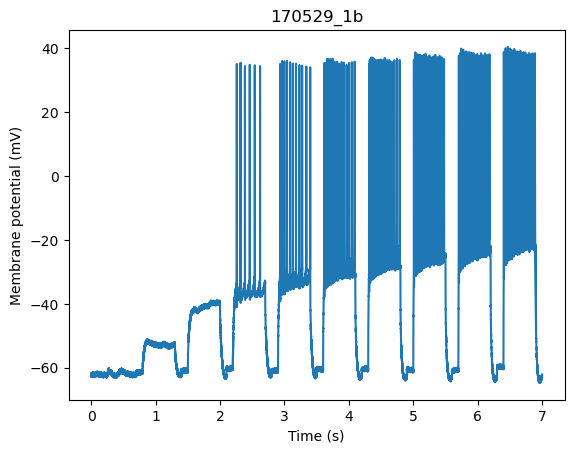

In [43]:
%matplotlib inline
#Fonction qui permet d'afficher le graphe selon certains caractéristiques
def plot_data(file_path): 
    #Récupération des données
    data = get_io(file_path).read(lazy=True)
    #Boucle pour lire chaque segment
    for segment in data[0].segments:
        #Stock la valeur de chaque segment dans "signal"
        signal = segment.analogsignals[0].load()
        #Création du graphe du temps selon le potentiel membranaire
        plt.plot(signal.times, signal)
    #Ajout des titres
    plt.title("170529_1b")
    plt.xlabel(f"Time ({signal.times.units.dimensionality})")
    plt.ylabel(f"Membrane potential ({signal.units.dimensionality})")
#Affiche le graphe du fichier demander
plot_data("downloads/170529_1b.ABF")

ignoring buggy nTelegraphEnable


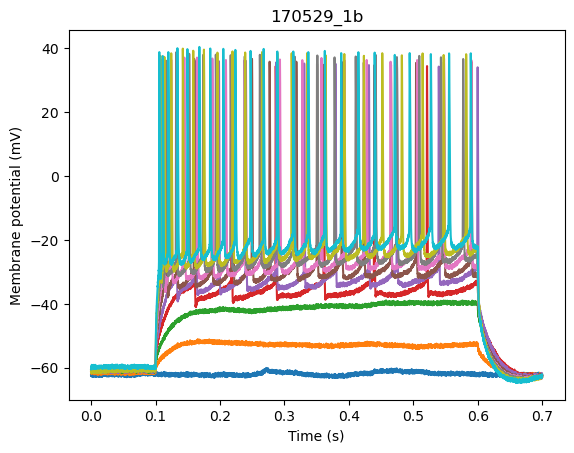

In [42]:
#Fonction qui permet de zoomer sur la zone d'intéret
def plot_data_zoom(file_path):
    #Lecture du fichier et stockage des valeurs
    reader = AxonIO(filename=file_path)
    block = reader.read_block()
    signal_analogique = block.segments[0].analogsignals[0]
    #conversion des valeurs en liste
    signal_numpy = np.array(signal_analogique)
    #création d'un tableau 
    df = pd.DataFrame(signal_numpy, columns=['Valeurs'])
    #Calcule la durée de chaque stimulus 
    part_size = len(df)//len(current_pulse_amplitudes)
    #Décomposition du segment par rapport au nombre d'impulsion
    data_parts = [df[i*part_size:(i+1)*part_size] for i in range(len(current_pulse_amplitudes))]
    #Création d'un tableau vide
    Data_pulse = pd.DataFrame()
    #Remplissage du tableau avec les segments décomposés
    for i, part in enumerate(data_parts):
        Data_pulse.insert(i, i ,data_parts[i]['Valeurs'].tolist())
    #Ajout du temps correcte en index
    times = np.linspace(0,0.7, len(Data_pulse)) 
    Data_pulse= Data_pulse.set_index(times)
    Data_pulse.columns = current_pulse_amplitudes
    indiceselect =[2,3,5,7,9]
    pulse_use = [current_pulse_amplitudes[i] for i in indiceselect]
    pulses = [f"{pulse_use} pA" for pulse_use in pulse_use]
    Data_pulse_graph= Data_pulse[pulse_use]
    Data_pulse_graph.columns = pulses
    Data_pulse_graph= Data_pulse_graph - 10
    fig, lab2= plt.subplots()
    #Création du graphe
    lab2.plot(Data_pulse_graph)
    lab2.axhline(y=-36.72, color='black', linestyle='--', label='-36.72 mV')
    #Ajout des titres
    plt.title("170518_4e")
    plt.xlabel(f"Time ({signal_analogique.times.units.dimensionality})")
    plt.ylabel(f"Membrane voltage ({signal_analogique.units.dimensionality})")
    lab2.legend(Data_pulse_graph,ncol=2, loc=0, fontsize='small')
#Affichage du graphe
plot_data_zoom("downloads/170518_4e.ABF")


In [ ]:
def compute_derivatives(df, delta_x=1):
    derivatives = df.diff() / delta_x
    #rounded_derivatives = derivatives.round(1)
    #return rounded_derivatives
    return derivatives
    
def get_zero_derivative_indices(df):
    zero_derivatives = df[df == 0]
    indices = {col: zero_derivatives[col].dropna().index.tolist() for col in df.columns}
    return indices

# Calculer les dérivées pour chaque colonne
derivatives_df = compute_derivatives(Data_pulse)

# Garder uniquement les valeurs égales à 0
zero_derivatives_df = get_zero_derivative_indices(derivatives_df)

derivatives_dict = {}
# Boucle pour extraire et assigner chaque dérivée à une variable nommée
for index in current_pulse_amplitudes:
    derivatives_dict[f'derivate_{index}'] = zero_derivatives_df[index]

filtered_derivatives_dict = {}
for key, lst in derivatives_dict.items():
    filtered_list = [value for value in lst if 0.1 <= value <= 0.6]
    filtered_derivatives_dict[key] = filtered_list

# Accès aux listes filtrées
derivate_0_filtered = filtered_derivatives_dict['derivate_0']
derivate_50_filtered = filtered_derivatives_dict['derivate_50']
derivate_100_filtered = filtered_derivatives_dict['derivate_100']
derivate_150_filtered = filtered_derivatives_dict['derivate_150']
derivate_200_filtered = filtered_derivatives_dict['derivate_200']
derivate_250_filtered = filtered_derivatives_dict['derivate_250']
derivate_300_filtered = filtered_derivatives_dict['derivate_300']
derivate_350_filtered = filtered_derivatives_dict['derivate_350']
derivate_400_filtered = filtered_derivatives_dict['derivate_400']
derivate_450_filtered = filtered_derivatives_dict['derivate_450']


In [ ]:
def recuperer_valeurs(df, indices):
    return df.loc[indices]

# Utilisation pour chaque liste d'indices
valeurs1 = recuperer_valeurs(Data_pulse[0], derivate_0_filtered)
valeurs2 = recuperer_valeurs(Data_pulse[50], derivate_50_filtered)
valeurs3 = recuperer_valeurs(Data_pulse[100], derivate_100_filtered)
valeurs4 = recuperer_valeurs(Data_pulse[150], derivate_150_filtered)
valeurs5 = recuperer_valeurs(Data_pulse[200], derivate_200_filtered)
valeurs6 = recuperer_valeurs(Data_pulse[250], derivate_250_filtered)
valeurs7 = recuperer_valeurs(Data_pulse[300], derivate_300_filtered)
valeurs8 = recuperer_valeurs(Data_pulse[350], derivate_350_filtered)
valeurs9 = recuperer_valeurs(Data_pulse[400], derivate_400_filtered)
valeurs10 = recuperer_valeurs(Data_pulse[450], derivate_450_filtered)

serie_val = [valeurs1,valeurs2,valeurs3,valeurs4,valeurs5,valeurs6,valeurs7,valeurs8,valeurs9,valeurs10]


In [ ]:
def consec(serie):
    masque = serie == serie.shift(-1)
    masque |= serie == serie.shift(1)
    return serie[masque]

def more_consec(serie_val):
    return [consec(serie)for serie in serie_val]

def mean_DBL(serie_DBL):
    return [serie.mean() for serie in serie_DBL]

serie_DBL = more_consec(serie_val)

moyenne_DBL = mean_DBL(serie_DBL)

In [ ]:
fig, ax = plt.subplots()
ax.plot(current_pulse_amplitudes, moyenne_DBL, color='blue',linewidth =3)
plt.xlabel("injected current (pA)")
plt.ylabel("absolute depolarization baseline(mV)")
plt.show()